## Activity Cliffs

Quando estamos desenvolvendo um modelo de SAR/SPR (relação estrutura-atividade/propriedade), fazemos a seguinte suposição:

_"Compostos com estruturas similares terão propriedades similares"_

Isso é equivalente a imaginar o espaço químico (um espaço imaginário contendo todas as moléculas nos eixos x e y, e o valor de sua atividade no eixo z) como sendo contínuo, sem grandes variações em pequenas distâncias. Porém, nem sempre esse é o caso: pequenas modificações em uma estrutura molecular podem influenciar significativamente a atividade (ou qualquer propriedade). Em um espaço físico, isso seria equivalente a um precipício (ravina, barranco, etc.), ou, em inglês, *cliff*. Dessa forma, quando um par de estruturas muito similares apresentam propriedades muito diferentes, dizemos que se trata de um *activity cliff*.

O que significa "ser muito similar"? O que significa "propriedades muito diferentes"? Não há definição estabelecida, portanto, escolha os valores de corte da forma que se encaixar melhor ao seu caso.

Neste notebook vamos verificar a existência de *activity cliffs* em um banco de dados de inibidores enzimáticos, e tentar explorar as razões moleculares por trás desses *cliffs*.

Vamos começar importando o chembl_webresource_client, para trabalharmos com estruturas do ChEMBL

In [1]:
from chembl_webresource_client.new_client import new_client

In [2]:
activities = new_client.activity

In [3]:
def get_inhibitors(target):
    """
    Input: código ChEMBL do alvo. Para descobrir o código do seu alvo, acesse o site do ChEMBL
        Exemplo: alvo = Catepsina B = "CHEMBL4072"
    Output: um dataframe contendo SMILES e pChEMBL values (atividade) dos inibidores do alvo
    """
    inhibitors = activities.filter(target_chembl_id=target, pchembl_value__isnull=False)
    data = [[item["canonical_smiles"], item["pchembl_value"]] for item in inhibitors]
    df = pd.DataFrame(data, columns=["SMILES", "pChEMBL"])
    return df

In [25]:
# Vamos procurar activity cliffs em inibidores de Catepsina B
df = get_inhibitors("CHEMBL4072")
# Remover linhas com dados faltando
df.dropna(inplace=True)
# Remover duplicatas
df = df.sort_values("pChEMBL", ascending=False).drop_duplicates(subset="SMILES").reset_index(drop=True)

df.head()

,SMILES,pChEMBL
0,CC(C)C[C@H](NC(=O)[C@H](CCCN=C(N)N)NC(=O)OCc1c...,9.92
1,CC[C@H](C)[C@H](NC(=O)NNC(=O)[C@H](Cc1ccccc1)N...,9.89
2,CC[C@@H](Cc1ccccc1)OC(=O)NN(C)C#N,9.60
3,CC[C@H](C)[C@H](NC(=O)NNC(=O)[C@H](CC(C)C)NC(=...,9.60
4,CC[C@H](C)[C@H](NC(=O)NNC(=O)[C@@H](NC(=O)[C@H...,9.52


In [27]:
len(df)

1218

Podemos definir *activity cliffs* de acordo com uma diferença de atividade (por exemplo, uma diferença de duas unidades logarítmicas) ou separando os compostos em "ativos" e "inativos" e definindo que um *cliff* contém um par de compostos similares no qual um é ativo e um é inativo.

Portanto, para definir nossos activity cliffs, vamos escolher o valor de pChEMBL = 6 como valor de corte: compostos com pChEMBL >= 6 serão considerados ativos, e inativos se pChEMBL < 6.

In [28]:
# A coluna pChEMBL é importada como string, precisamos convertê-la a float
df["Active"] = df["pChEMBL"].astype('float64') >= 6

# Número de compostos considerados "ativos"
df["Active"].sum()

531

Já temos os valores de atividade dos compostos. Agora, precisamos comparar as similaridades entre as estruturas. Uma forma comum de fazer isso é utilizando *fingerprints* moleculares.

Como exemplo, vamos utilizar os MACCS *fingerprints*, que consistem em uma lista contendo 166 valores (bits) que podem conter os números 0 ou 1. O valor 0 indica a ausência de uma sub-estrutura, e o valor 1 indica sua ausência. Por exemplo, o 42° bit de um MACCS *fingerprint* corresponde à presença ou ausência de um átomo de flúor: se a estrutura contém flúor, o valor desse bit será 1, caso contrário, será 0. As definições de cada bit podem ser encontradas [neste link](https://github.com/rdkit/rdkit/blob/master/rdkit/Chem/MACCSkeys.py).

Após calcular os *fingerprints* para todas as estruturas, usaremos o valor do coeficiente de Tanimoto igual a 0.9 como valor de corte para similaridade. Em resumo, o coeficiente de Tanimoto compara dois *fingerprints* moleculares e retorna um valor entre 0 e 1; quanto mais próximo de 1, maior a similaridade. Assim, pares de compostos contendo um ativo e um inativo, cuja similaridade (coeficiente de Tanimoto) seja maior que 0.9 serão considerados *activity cliffs*.

In [45]:
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys

# Criar coluna com RDKit Mol
df["rdkit_mol"] = df["SMILES"].apply(Chem.MolFromSmiles)

# Criar coluna com MACCS fingerprints
df["Morgan"] = df["rdkit_mol"].apply(lambda mol: AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024))
# df["MACCS"] = df["rdkit_mol"].apply(MACCSkeys.GenMACCSKeys)

In [46]:
# Calcular activity cliffs
cliffs = []
fps = df["Morgan"].to_list()

for i in range(len(fps)):
    for j in range(i+1, len(fps)):
        sim = DataStructs.FingerprintSimilarity(fps[i], fps[j], metric=DataStructs.TanimotoSimilarity)
        if (sim > 0.9) and (df.loc[i]["Active"] != df.loc[j]["Active"]):
            # Append the indexes of the pair in order (active, inactive)
            if df.loc[i]["Active"]:
                cliffs.append((i,j))
            else:
                cliffs.append((j,i))

In [59]:
# Criar listas com os RDKit Mol de cada cliff e legendas contendo o índice e o valor da atividade
ms = []
leg = []
for item in cliffs:
    ms.append(df.loc[item[0]]["rdkit_mol"])
    leg.append(', '.join((str(item[0]), df.loc[item[0]]["pChEMBL"])))
    ms.append(df.loc[item[1]]["rdkit_mol"])
    leg.append(', '.join((str(item[1]), df.loc[item[1]]["pChEMBL"])))

In [60]:
# Quantos cliffs foram encontrados
len(cliffs)

14

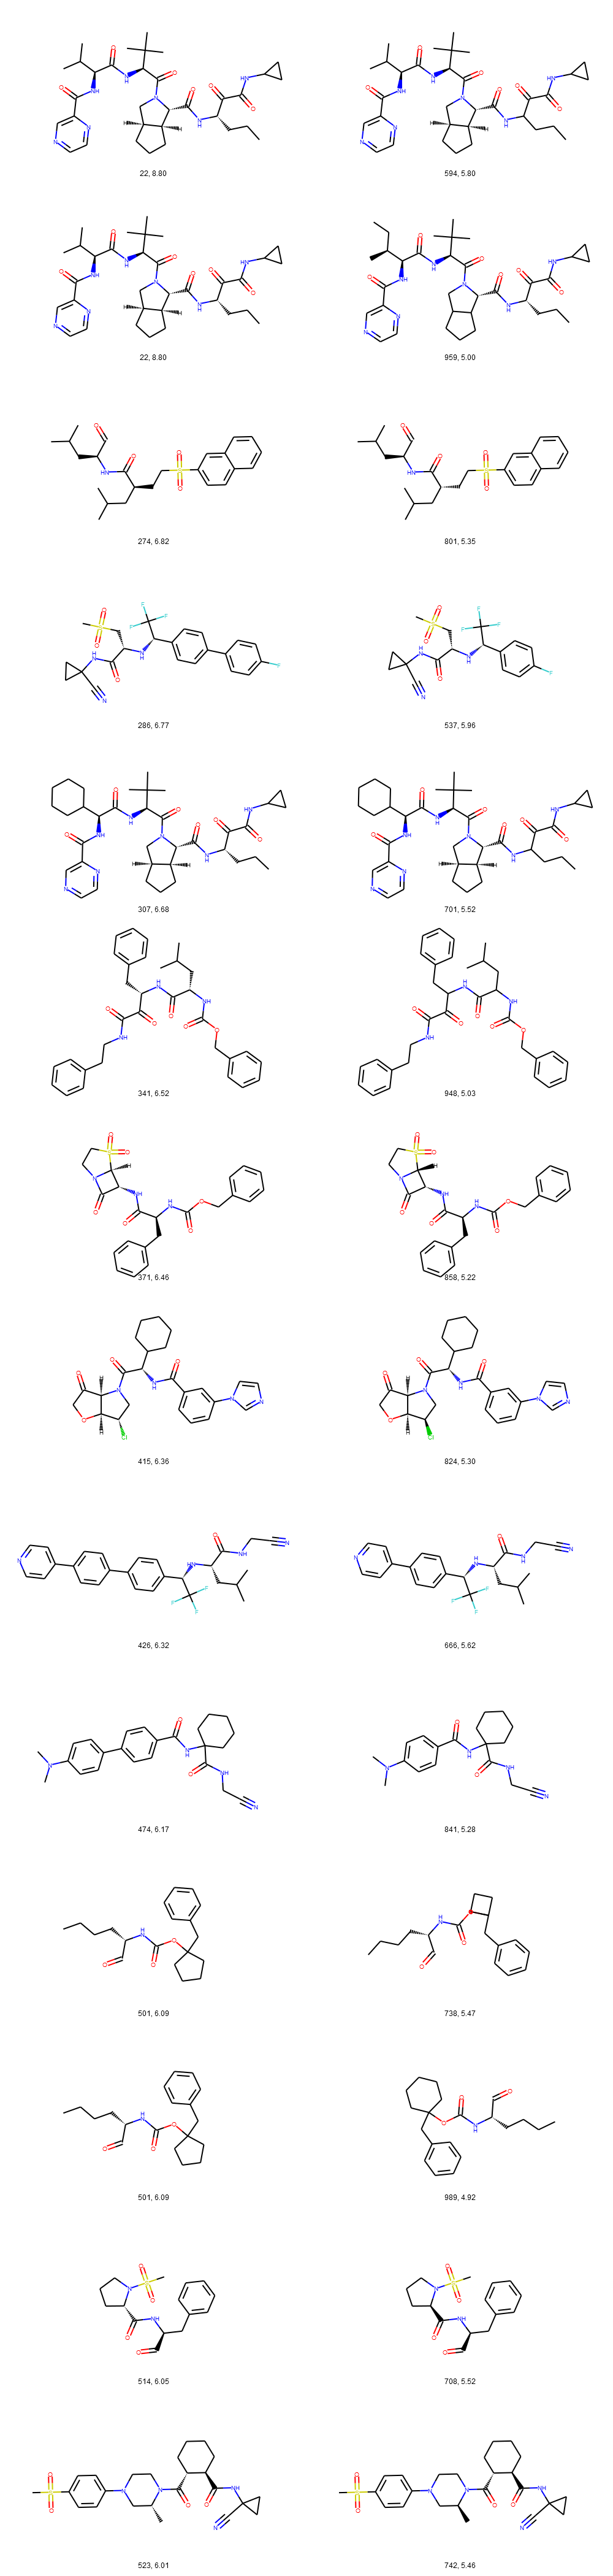

In [65]:
img = Draw.MolsToGridImage(ms, molsPerRow=2, subImgSize=(500, 300), legends=leg)
img

Vemos que muitos *activity cliffs* correspondem a isômeros ou a pares moleculares com diferença de um grupo, como um anel aromático.